In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.ensemble
import sklearn.svm
import pathlib
import pickle
import imblearn

In [2]:
# Paths 
base_dir = pathlib.Path('/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS')
train_spectra_path = base_dir / '5b_Rad_Georef_SGC_PCA_TrainValSplit/Training_Spectra/20210825_OlbergAreaS_Spectra.npz'
val_spectra_path = base_dir / '5b_Rad_Georef_SGC_PCA_TrainValSplit/Validation_Spectra/20210825_OlbergAreaS_Spectra.npz'
random_forest_save_path = base_dir / 'X_SavedModels_RF_SVM/20210825_OlbergAreaS_RandomForest_InpaintedDataset.pkl'
svm_save_path = base_dir / 'X_SavedModels_RF_SVM/20210825_OlbergAreaS_SVM_InpaintedDataset.pkl'


In [3]:
# Load training dataset
with np.load(train_spectra_path) as npz_files:
    X_train = npz_files['X']
    y_train = npz_files['y']
print(f'{X_train.shape}')
print(f'{y_train.shape}')

(3270821, 8)
(3270821,)


In [4]:
# Load validation dataset
with np.load(val_spectra_path) as npz_files:
    X_val = npz_files['X']
    y_val = npz_files['y']
print(f'{X_val.shape}')
print(f'{y_val.shape}')

(689903, 8)
(689903,)


In [5]:
# Create a random forest model
rfc = sklearn.ensemble.RandomForestClassifier(
    n_estimators=20,            # Ensemble of 30 decision trees
    min_samples_leaf=15,        # Stop splitting data when number of samples < 15 (faster)
    max_samples=0.1)            # Use only 60% of data for each estimator (faster)
# max_samples=0.6)            # Use only 60% of data for each estimator (faster)

In [6]:
# Train classifier (takes about 1-2 minutes)
rfc.fit(X_train,y_train)

RandomForestClassifier(max_samples=0.1, min_samples_leaf=15, n_estimators=20)

In [7]:
# Save the model
pickle.dump(rfc,open(random_forest_save_path,'wb'))

In [8]:
# Use classifier to make predictions on validation data
y_pred_rf = rfc.predict(X_val)

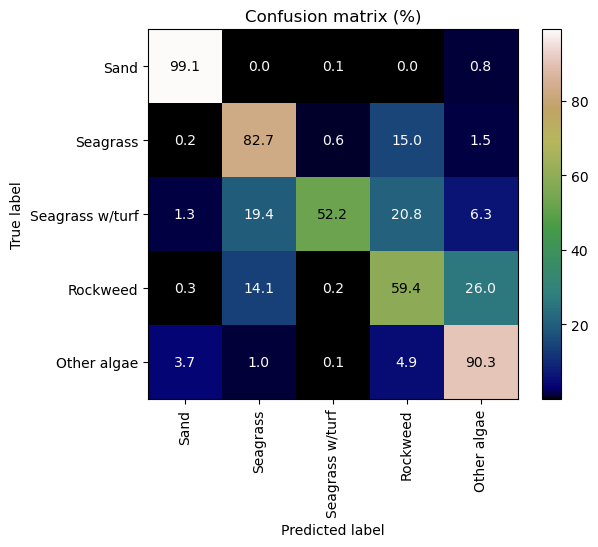

In [9]:
# Show confusion matrix
display_labels = ['Sand', 'Seagrass', 'Seagrass w/turf','Rockweed','Other algae']
confusion_matrix = sklearn.metrics.confusion_matrix(y_val,y_pred_rf,normalize='true')
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix*100,display_labels=display_labels)
disp.plot(xticks_rotation='vertical',cmap='gist_earth',values_format='.1f')
plt.title('Confusion matrix (%)')
plt.show()

In [10]:
# Create under-sampled version of X and y
#rus = imblearn.under_sampling.RandomUnderSampler()

rng = np.random.default_rng()
n_samp_us = 100000
random_indices = rng.integers(0,len(y_train),size=n_samp_us)
X_train_us = X_train[random_indices,:]
y_train_us = y_train[random_indices]

In [11]:
# Create SVM model
svm = sklearn.svm.SVC(C=0.5,kernel='rbf',gamma='scale')

In [12]:
# Train SVM model
svm.fit(X_train_us,y_train_us)

SVC(C=0.5)

In [14]:
# rng = np.random.default_rng()
# n_samp_val_us = 100000
# random_indices_val = rng.integers(0,len(y_val),size=n_samp_val_us)
# X_val_us = X_val[random_indices_val,:]
# y_val_us = y_val[random_indices_val]

In [15]:
# Use classifier to make predictions on validation data
y_pred_svm = svm.predict(X_val)

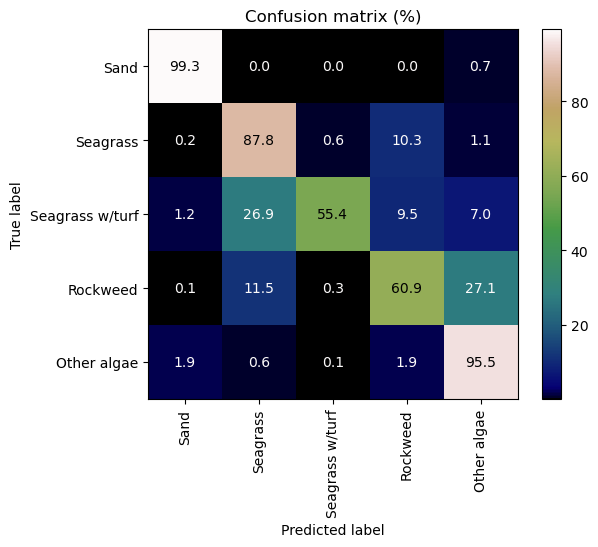

In [16]:
# Show confusion matrix
display_labels = ['Sand', 'Seagrass', 'Seagrass w/turf','Rockweed','Other algae']
confusion_matrix = sklearn.metrics.confusion_matrix(y_val,y_pred_svm,normalize='true')
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix*100,display_labels=display_labels)
disp.plot(xticks_rotation='vertical',cmap='gist_earth',values_format='.1f')
plt.title('Confusion matrix (%)')
plt.show()

In [17]:
# Save SVM model
pickle.dump(svm,open(svm_save_path,'wb'))